In [1]:
import bs4 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from multiprocessing.pool import ThreadPool
from tqdm import tqdm
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.common.exceptions import ElementClickInterceptedException, StaleElementReferenceException
import os
from random_user_agent.user_agent import UserAgent
from random_user_agent.params import SoftwareName, OperatingSystem
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import json
import pickle
import urllib
sns.set()

In [2]:
from multiprocessing.pool import Pool
from contextlib import closing

In [3]:
from functools import partial

In [4]:
def multiprocess_func(main_input, func, additional_inputs=None,
                      gather_func=None, to_split=True, gather_func_args=None,
                      chunk_size=100, n_processes=8):
    if not gather_func_args:
        gather_func_args = []
    if not additional_inputs:
        additional_inputs = []
    if not gather_func:
        gather_func = lambda x: [z for i in x for z in i]
    if to_split:
        splitted = [(main_input[i:i + chunk_size], *additional_inputs) if additional_inputs else main_input[i:i + chunk_size]\
                    for i in range(0, len(main_input), chunk_size)]
    else:
        splitted = [(i, *additional_inputs) if additional_inputs else i for i in main_input]
    with closing(Pool(n_processes)) as p:
        result = list(tqdm(p.imap(func, splitted),
                           total=len(splitted)))
    return gather_func(result, *gather_func_args)

In [5]:
def process_buble(x):
    return float('.'.join(x))

In [6]:
def bs4_parse_reviews(input_tuple):
    page_to_parse, hotel_name = input_tuple
    records = []
    try:
        for review_page in bs4.BeautifulSoup(page_to_parse).find_all('div', {'class':'WAllg _T'}):

            record = {}
            record['overall_rating'] = process_buble(review_page.find('div',{'data-test-target':'review-rating'})\
                                           .span['class'][-1].split('_')[-1])
            per_type_bubble = review_page.find_all('div', {'class':'hemdC S2 H2 WWOoy'})

            if per_type_bubble:
                for j in per_type_bubble:
                    record[j.text+'_rating'] = process_buble(j.span.span['class'][-1].split('_')[-1])


            record['review'] = review_page.find('div',{'class':'fIrGe _T'}).text
            record['hotel_name'] = hotel_name
            
            records.append(record)
    except Exception as ex:
        print(ex)
        
    return records

In [7]:
def read_file(path):
    with open(path, 'r') as f:
        return f.read()

In [8]:
def parse_reviews_multiproc(name, abs_path):
    path = os.path.join(abs_path,name)
    records = []
    for path_page in os.listdir(path):
        page = read_file(os.path.join(path,path_page))
        records.extend(bs4_parse_reviews((page, name)))
    return records

In [9]:
ABS_PATH = 'trip_advisor_data_hotels'


In [10]:
hotels_df = pd.read_csv('hotels_links.csv')

In [11]:
hotels_to_load = hotels_df[hotels_df['parsed']==True]['title'].values.tolist()

In [12]:
partial_parse_reviews_multiproc = partial(parse_reviews_multiproc, abs_path=ABS_PATH)


In [13]:
reviews = multiprocess_func([i for i in os.listdir(ABS_PATH) if not i.startswith('.')],
                  func=partial_parse_reviews_multiproc,
                  to_split=False,
                 n_processes=8)

100%|████████████████████████████████████| 2848/2848 [08:19<00:00,  5.71it/s]


In [14]:
reviews = pd.DataFrame(reviews)

In [15]:
reviews = reviews.drop_duplicates(['review', 'hotel_name'])

In [16]:
reviews.head()

,overall_rating,review,hotel_name,Номера_rating,Расположение_rating,Обслуживание_rating,Чистота_rating,Цена/качество_rating,Качество сна_rating,Стойка регистрации_rating,"Бизнес-услуги (например, доступ в Интернет)_rating"
0,5.0,Уже не первый раз останавливаемся в отеле Тайм...,Time Hotel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,Большое спасибо гостинице и персоналу за теплы...,Time Hotel,3.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN
2,4.0,"Когда мы впервые приехали в Киев, мы выбрали э...",Time Hotel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.0,Останавливались здесь на две ночи. Регистрация...,Time Hotel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,"Отличный персонал ,чистый уютный номер.Админис...",Time Hotel,5.0,NaN,5.0,5.0,NaN,NaN,NaN,NaN


In [25]:
reviews.shape

(80772, 11)

<AxesSubplot:>

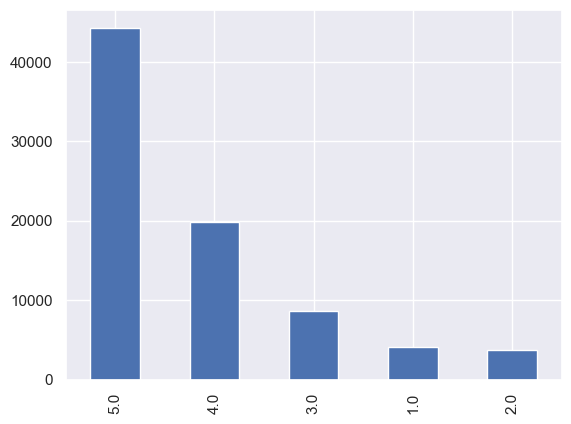

In [18]:
reviews['overall_rating'].value_counts().plot.bar()

In [24]:
reviews['overall_rating'].value_counts()

5.0    44339
4.0    19889
3.0     8669
1.0     4109
2.0     3766
Name: overall_rating, dtype: int64

In [23]:
reviews.isna().sum()

overall_rating                                            0
review                                                    0
hotel_name                                                0
Номера_rating                                         53505
Расположение_rating                                   53353
Обслуживание_rating                                   34056
Чистота_rating                                        52996
Цена/качество_rating                                  52992
Качество сна_rating                                   54861
Стойка регистрации_rating                             80467
Бизнес-услуги (например, доступ в Интернет)_rating    80560
dtype: int64

In [22]:
reviews[reviews['overall_rating']==3.0].sample()['review'].values[0]

"L'hotel non l'ho provato ma sono stato al ristorante Shengen, collegato all'hotel, per cena. Il locale è molto bello e bene arredato. Il servizio è buono. Il cibo anche. Il menù è buono se non fosse per il fatto che molti dei piatti non sono disponibili, specialmente quelli di pesce. Infatti ho ordinato dal menù una dorata e non era disponibile. Poi il salmone ed era finito. Lista vini del un po' povera. Insomma, ho avuto l'impressione che sia molto fumo e niente arrosto. Da questo i tre punti."

In [26]:
reviews.to_csv('hotel_reviews.csv', index=False)